 ### Sentiment analysis on skin care products

# *Dictionary-based sentiment analysis (2/2)*

*In this notebook, we are going to find out whether negation handling is effective or not. The Sections 1 and 2 are the same as the ones in the dictionary-based sentiment analysis (1/2).*

##  1. Load the corpus

In [8]:
import pandas as pd

In [9]:
df_small_corpus  = pd.read_csv('small_corpus.csv')

In [10]:
df_small_corpus.head()

,reviews,rating
0,I got soap in a bottle of what is supposted to...,1.0
1,I used this on my kids and my fair-skinned hus...,1.0
2,After months of emergency use simply because m...,1.0
3,"The product is a facial cream, but the picture...",1.0
4,I have been buying olive derived 100% Squalane...,1.0


##  2. Get the opinion lexicon 


*We use opinion lexicon from nltk corpus package.*

In [11]:
import nltk
from nltk.corpus import opinion_lexicon

In [12]:
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

*Let's check out the length of the each list.*

In [13]:
len(pos_words), len(neg_words)

(2006, 4783)

##  3. Calculate the sentiment scores 


*If negation is True, the tokenize() function marks negations during the tokenization. Furthermore, if a token in the opinion lexicon is negatated, its polarity is counted as opposite.*

In [14]:
import nltk.sentiment.util
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords


#Returns true if a word is alphabetic or inludes _NEG mark. 
def is_alpha_or_NEG(word):
    if word.find('_NEG') != -1 :
        return True
    return word.isalpha()

#Tokenizes text and remove non-alphabetic tokens as well as stopwords.  
def tokenize(review, negation=False):
    stop_words = stopwords.words('english')
    sentences = sent_tokenize(review)
    tokens = []
    for sent in sentences:
        sent = sent.lower()
        words = word_tokenize(sent)
        if negation:
            with_negation = nltk.sentiment.util.mark_negation(words)
            tokens += [word for word in with_negation if (is_alpha_or_NEG(word) and word not in stop_words)]
        else:
            tokens += [word for word in words if (word.isalpha() and word not in stop_words)]
    return tokens

#Calculates sentiment score for a review based on the counts of the positive and negative words it includes.
def sentiment_score(review, negation=False):
    tokens  = tokenize(review, negation)
    pos = 0
    neg = 0
    for word in tokens:
        if negation and word.find('_NEG') != -1:
            mark_word = word.replace('_NEG', '')
            if mark_word in pos_words:
                neg += 1
            elif mark_word in neg_words:
                pos += 1
            continue
        if word in pos_words:
            pos += 1
        elif word in neg_words:
            neg += 1
    if len(tokens) > 0:
        return (pos - neg) / len(tokens)
    return 0

*Calculating sentiment scores with and without negation handling for each review.*

In [15]:
sentiment_scores  = [] #Stores sentiment scores without negation handling
sentiment_scores_w_neg  = [] #Stores sentiment scores with negation handling

reviews  = list(df_small_corpus.reviews) #All the review texts

for review in reviews:
    sentiment_scores.append(sentiment_score(review))
    sentiment_scores_w_neg.append(sentiment_score(review, True))

*Lets add the calculated sentiment_scores into the df_small_corpus.*

In [16]:
df_small_corpus ['dic_based_score'] = sentiment_scores
df_small_corpus ['dic_based_score_w_neg'] = sentiment_scores_w_neg

In [17]:
df_small_corpus

,reviews,rating,dic_based_score,dic_based_score_w_neg
0,I got soap in a bottle of what is supposted to...,1.0,0.000000,0.000000
1,I used this on my kids and my fair-skinned hus...,1.0,0.038462,0.031250
2,After months of emergency use simply because m...,1.0,0.028986,-0.021053
3,"The product is a facial cream, but the picture...",1.0,-0.031250,-0.020408
4,I have been buying olive derived 100% Squalane...,1.0,0.065789,0.058140
...,...,...,...,...
4495,I use it before bed with Speedlash eyelash gro...,5.0,-0.133333,0.000000
4496,It might be generic but it does the job withou...,5.0,0.181818,0.181818
4497,I have been using this eye cream for about a y...,5.0,0.054054,0.054054
4498,Exactly as pictured Great product. Will order ...,5.0,0.100000,0.250000


##  4. Experiment and Result


### *4.1 Converting the ratings and scores into the same scale*

*In order to measure how accurate the dictionary-based method, we need to convert the ratings and dictionary-based scores into the same scale.*

*Here we convert the sentiment scores and ratings into three categories such as positive, negative or neutral.* 

*The categories positive, negative, and neutral are labeled as 2, 0, and 1, respectively.* 

In [18]:
# Returns 2, 1, or 0 based on the given score and threshold. 
def label(score, thresh):
    #postive threshold
    if round(score,2) >= thresh[0]:
        return 2
    #negative threshold
    if round(score,2) <= thresh[1]:
        return 0
    return 1

*We define ratings 4 and 5 as positive, 1 and 2 as negative, 3 as neutral. Let's save the converted ratings in "target".*

In [19]:
target = []
for i in range(len(df_small_corpus)):
    target.append(label(df_small_corpus.rating[i], (4, 2)))

*We converted the rating values (1.0 to 5.0) into the 0 (negative), 1 (neutral) and 2 (positive) labels.*

*However, we don't know what is the best threshold for dictionary-based scores when we divide into labels. The find_best_threshold() function calculates accuracies for different threshold values and prints the threshold that has the highest accuracy.*

*The accuracy is calculated by sklearn.metrics's accuracy_score which takes target labels and predictions.*

In [26]:
from sklearn.metrics import accuracy_score
import numpy as np

def find_best_threshold():
    best_acc = 0
    best_thresh = ()
    for num in np.arange(0.01, 1.01, 0.01):
        sent_label = []
        thresh = (num, -num)
        for i in range(len(df_small_corpus)):
            #Label with the thresholds
            sent_label.append(label(df_small_corpus.dic_based_score[i], thresh))
        acc = accuracy_score(target, sent_label) 
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh
    print(best_thresh, best_acc)

In [33]:
find_best_threshold()

(0.01, -0.01) 0.44266666666666665


*As a result of find_best_threshold(), the best threshold was (0.01 and -0.01). So, if the score is over 0.01, it is labeled as positive (2) and if the score is below -0.01, it is labeld as negative(0). For the other values, it is labeled as neutral (1).*

### *4.2 Accuracy of the dictionary-based method*

*Based on the threshold values we found in 4.1, lets convert the dictionary-based scores into labels.*

In [27]:
#Store labels
sent_label = []  #sentiment labels without negation handling
sent_label_w_neg = [] #sentiment labels with negation handling

#Store accuracies
acc_sent_label = []   #accuracies of sent_label
acc_sent_label_w_neg = [] #accuracies of sent_label_w_neg

# Convert scores into labels
for i in range(len(df_small_corpus)):
    sent_label.append(label(df_small_corpus.dic_based_score[i], (0.01, -0.01)))
    sent_label_w_neg.append(label(df_small_corpus.dic_based_score_w_neg[i], (0.01, -0.01)))

# Calculate cumulative accuracies     
for j in range(100, len(df_small_corpus)):
    acc_sent_label.append(accuracy_score(target[0:j], sent_label[0:j]))
    acc_sent_label_w_neg.append(accuracy_score(target[0:j], sent_label_w_neg[0:j]))

*Let's plot the accuracies.*

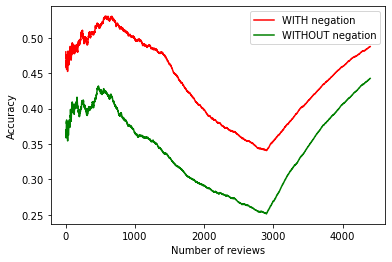

In [28]:
import matplotlib.pyplot as plt
plt.plot(range(len(acc_sent_label_w_neg)), acc_sent_label_w_neg, label='WITH negation', color='red')
plt.plot(range(len(acc_sent_label)), acc_sent_label, label='WITHOUT negation', color='green' )
plt.legend()
plt.xlabel('Number of reviews')
plt.ylabel('Accuracy')
plt.show()

*The above graph shows the accuracies of the dictionary-based sentiment analysis for the reviews. The accuracies were higher when we handled negation.* 

*Now, let's see the detailed measures using classification_report from sklearn.metrics.*

In [29]:
from sklearn.metrics import classification_report
target_names = ['Negative', 'Neutral', 'Positive']

In [30]:
print(classification_report(target, sent_label, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.58      0.34      0.43      1500
     Neutral       0.37      0.16      0.23      1500
    Positive       0.42      0.83      0.56      1500

    accuracy                           0.44      4500
   macro avg       0.46      0.44      0.40      4500
weighted avg       0.46      0.44      0.40      4500



In [31]:
print(classification_report(target, sent_label_w_neg, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.56      0.48      0.51      1500
     Neutral       0.40      0.20      0.27      1500
    Positive       0.48      0.78      0.59      1500

    accuracy                           0.49      4500
   macro avg       0.48      0.49      0.46      4500
weighted avg       0.48      0.49      0.46      4500



*The overall accuracies were 0.44 and 0.49 for without and with negation, respectively. The f1-scores were the lowest for the neutral label. If we look the neutral label, the recall values were lowest among the others. This means that the most of the neutral reviews were not classified correctly.* 

*Looking at the graph below, the most reviews were classified as 2 (positive).*

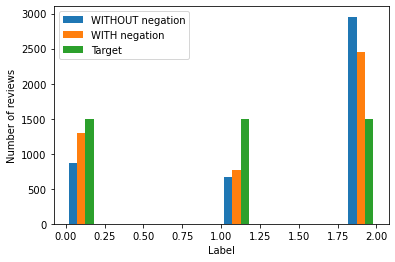

In [62]:
plt.hist([sent_label, sent_label_w_neg, target],  label=['WITHOUT negation', 'WITH negation', 'Target'])
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.legend()
plt.show()

##  5. Conclusion


*In this notebook, we implemented dictionary-based sentiment analysis. We classified the reviews into three classes such as negative, neutral and positive. Our classification accuracy was higher when we handled negations.*

*The dictionary-based method is simple and easy to implement, but it has limitations since it considers only the words in the dictionary. For example "The veins are still there, red as ever" does not include any opinion words, but expresses negative opinion for skin care products. Therefore we need to consider words that are not in the dictionary as well.*   